**Importation des bibliothèques nécessaires pour le traitement des images, la construction du modèle CNN, et l'analyse des résultats.**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from collections import Counter


**Chargement du dataset à partir du répertoire spécifié et préparation des images :**

In [ ]:
# Définir le chemin du dataset
data_dir = r'C:\Users\Ashref\Desktop\CAR DATASET\CAR DATASET'
# Chargement du dataset à partir du répertoire
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(224, 224),
    batch_size=32 # Nombre d'images par lot
)

Found 1652 files belonging to 20 classes.


---
Division du dataset en trois ensembles :

> 70% pour l'entraînement,
20% pour la validation,
10% pour le test.

In [ ]:
# Diviser le dataset en ensembles d'entraînement, validation et test
train_size = int(0.7 * len(dataset)) # 70% pour l'entraînement
val_size = int(0.2 * len(dataset)) # 20% pour la validation
test_size = len(dataset) - train_size - val_size # 10% pour le test


# Extraction des images d'entraînement, validation et test
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size + val_size)

# Normalisation :

> Les valeurs des pixels des images sont divisées par 255 pour les ramener dans une plage [0,1]. Cela accélère la convergence du modèle.




In [ ]:
# Normalisation des valeurs des pixels entre 0 et 1
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Préchargement

>  Optimise les performances de lecture et le traitement des données en utilisant prefetch




In [ ]:
# Optimisation des performances via le préchargement
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Extraction des noms et numero des i pour chaque classe.


> Permet de comprendre si le dataset est équilibré ou déséquilibré



In [ ]:
# Analyser les classes et vérifier l'équilibre
class_names = dataset.class_names # Obtenir les noms des classes
print("Noms des classes :", class_names)

# Obtenir les étiquettes de toutes les images pour une analyse globale
y_train = np.concatenate([y for x, y in dataset], axis=0)

class_counts = dict(Counter(y_train))# Compter les occurrences par classe

# Construction du modèle CNN personnalisé
class_counts = {class_names[index]: count for index, count in class_counts.items()}

print("Class Counts:\n", class_counts)

Noms des classes : ['GMC Canyon Extended Cab 2012', 'GMC Yukon Hybrid SUV 2012', 'HUMMER H2 SUT Crew Cab 2009', 'Hyundai Azera Sedan 2012', 'Hyundai Sonata Hybrid Sedan 2012', 'Hyundai Veloster Hatchback 2012', 'Jaguar XK XKR 2012', 'Jeep Liberty SUV 2012', 'Lamborghini Gallardo LP 570-4 Superleggera 2012', 'Land Rover Range Rover SUV 2012', 'McLaren MP4-12C Coupe 2012', 'Mercedes-Benz S-Class Sedan 2012', 'Nissan Juke Hatchback 2012', 'Nissan NV Passenger Van 2012', 'Rolls-Royce Phantom Sedan 2012', 'Suzuki SX4 Sedan 2012', 'Toyota 4Runner SUV 2012', 'Volkswagen Golf Hatchback 2012', 'Volvo C30 Hatchback 2012', 'smart fortwo Convertible 2012']
Class Counts:
 {'Jaguar XK XKR 2012': 93, 'McLaren MP4-12C Coupe 2012': 84, 'Toyota 4Runner SUV 2012': 81, 'Volvo C30 Hatchback 2012': 83, 'Nissan Juke Hatchback 2012': 88, 'Nissan NV Passenger Van 2012': 77, 'Jeep Liberty SUV 2012': 89, 'Volkswagen Golf Hatchback 2012': 86, 'smart fortwo Convertible 2012': 80, 'Lamborghini Gallardo LP 570-4 Sup



---



# Distribution des classes et exemples d'images

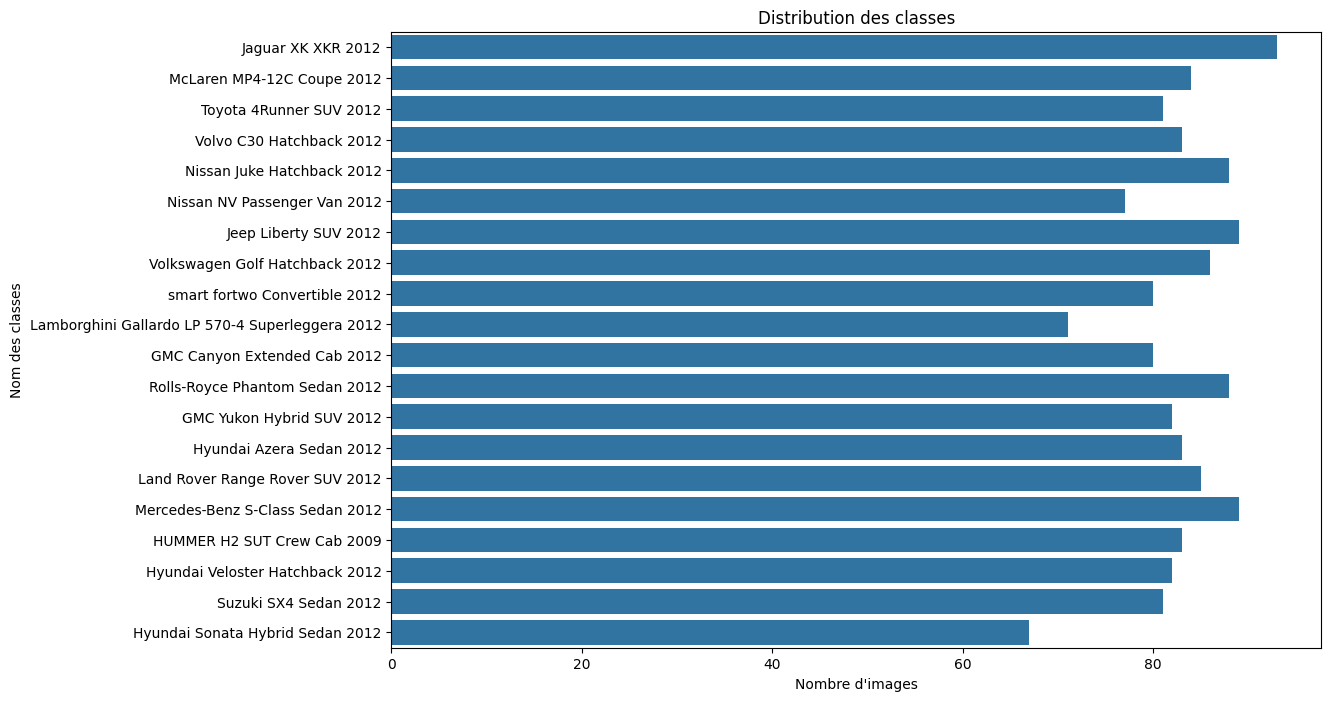

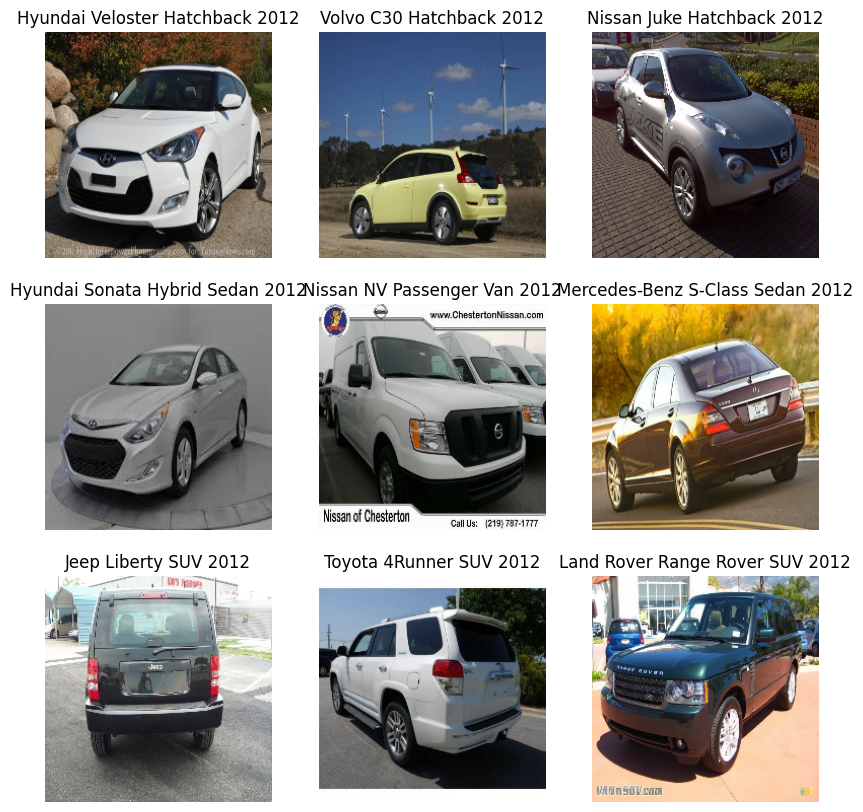

In [ ]:
# Visualize class distribution
plt.figure(figsize=(12, 8))
sns.barplot(x=list(class_counts.values()), y=list(class_counts.keys())) # Create a bar plot
plt.title("Distribution des classes")
plt.xlabel("Nombre d'images")
plt.ylabel("Nom des classes")
plt.show()

# Afficher des échantillons d'images
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):  # Montrer les 9 premières images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

---
Modèle CNN personnalisé


In [ ]:
# 3 blocs convolutionnels (avec pooling) pour capturer les caractéristiques des images.

custom_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)), # Réduction de la taille de l'image
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'), # Couche dense avec 512 neurones
    Dropout(0.5), # Réduction du surapprentissage
    Dense(len(class_names), activation='softmax') # Couche de sortie avec 20 classes
])

---

# Compilation du modèle

In [ ]:
custom_cnn.compile(
    optimizer='adam', # Algorithme d'optimisation Adam
    loss='sparse_categorical_crossentropy', # Fonction de perte pour classification multi-classes
    metrics=['accuracy'] # Mesure de performance
)

# Entraînement du modèle


In [ ]:
history_cnn = custom_cnn.fit(
    train_ds, # Ensemble d'entraînement
    validation_data=val_ds, # Ensemble de validation
    epochs=50, # Nombre maximum d'epochs
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.0488 - loss: 3.8705 - val_accuracy: 0.1063 - val_loss: 2.9661
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.0945 - loss: 2.9266 - val_accuracy: 0.1406 - val_loss: 2.8275
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.1564 - loss: 2.7464 - val_accuracy: 0.2500 - val_loss: 2.6401
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.2939 - loss: 2.3649 - val_accuracy: 0.3625 - val_loss: 2.3160
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.4922 - loss: 1.7570 - val_accuracy: 0.3969 - val_loss: 2.1759
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.7191 - loss: 0.9565 - val_accuracy: 0.4812 - val_loss: 2.0566
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.8907 - loss: 0.4480 - val_accuracy: 0.5188 - val_loss: 2.3094
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.9359 - loss: 0.2731 - val_accuracy: 0.5406 - val_loss



---

# Analyse des résultats du modèle CNN

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.4683 - loss: 5.4322
Custom CNN Test Accuracy: 0.472
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step
                                                 precision    recall  f1-score   support

                   GMC Canyon Extended Cab 2012       0.25      0.12      0.17         8
                      GMC Yukon Hybrid SUV 2012       0.00      0.00      0.00         9
                    HUMMER H2 SUT Crew Cab 2009       0.00      0.00      0.00         4
                       Hyundai Azera Sedan 2012       0.00      0.00      0.00         6
               Hyundai Sonata Hybrid Sedan 2012       0.00      0.00      0.00         5
                Hyundai Veloster Hatchback 2012       0.20      0.07      0.11        14
                             Jaguar XK XKR 2012       0.07      0.12      0.09         8
                          Jeep Liberty SUV 2012       0.00      0.00      0.00         9
Lamborghini Gallardo LP 570-4 Superleggera 2012       

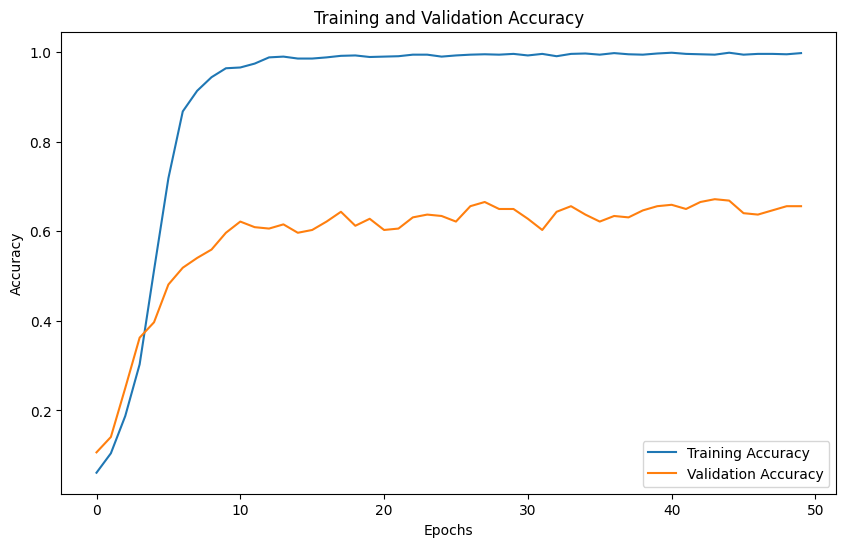

In [ ]:
# Le modèle est évalué sur les données de test.
cnn_test_loss, cnn_test_acc = custom_cnn.evaluate(test_ds)
print(f"Custom CNN Test Accuracy: {cnn_test_acc:.3f}")

y_pred = np.argmax(custom_cnn.predict(test_ds), axis=-1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

print(classification_report(y_true, y_pred, target_names=class_names))

# Tracer la précision d'entraînement et de validation pour le modèle CNN personnalisé
plt.figure(figsize=(10, 6))
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Performance du modèle CNN :**
> Précision d'entraînement : 99.81% (élevée), ce qui montre que le modèle apprend très bien sur les données d'entraînement.

> Précision de validation : 65.62%, ce qui révèle une différence notable par rapport à l'entraînement, suggérant un légère surapprentissage.

> Perte de validation : Stagne ou augmente légèrement après 20 époques, confirmant le surapprentissage.


# Construction du modèle avec Transfer Learning et VGG16

In [ ]:
base_model = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

*   Fine-tuning


In [ ]:
# Rendre le modèle de base entraînable
base_model.trainable = True
#décongeler les 4 dernières couches
fine_tune_at = len(base_model.layers) - 4
# Congeler toutes les couches avant le point de fine-tuning
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

* Reconstruire le modèle avec le modèle de base affiné


In [ ]:
# Ajouter le modèle de base comme première couche
model = Sequential([
    base_model,
    # Aplatir la sortie du modèle de base
    Flatten(),
    # Appliquer le dropout pour la régularisation afin d'éviter le surapprentissage
    Dropout(0.5),
    # Ajouter une couche dense avec activation ReLU et régularisation L2
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    # Ajouter la couche de sortie finale avec activation softmax pour la classification multi-classes
    Dense(20, activation='softmax')  #20 classes de voitures
])

# Compilation du modèle

In [ ]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Appliquation de l'augmentation des données

In [ ]:
# Créer une séquence d'opérations d'augmentation de données
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
])
# Appliquer l'augmentation des données à l'ensemble d'entraînement
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Définir les callbacks

In [ ]:
# Callback pour l'arrêt précoce de l'entraînement
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,                  # Arrêter si aucune amélioration pendant 5 époques
    restore_best_weights=True    # Restaurer les meilleurs poids du modèle
)

# Callback pour la réduction du taux d'apprentissage
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,                  # Réduire le taux d'apprentissage de moitié
    patience=3,                  # Attendre 3 époques sans amélioration
    min_lr=1e-6                  # Taux d'apprentissage minimum
)

# Callback pour la sauvegarde du meilleur modèle
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras', # Chemin d'accès pour enregistrer le modèle
    monitor='val_loss',          # Surveiller la perte de validation
    save_best_only=True          # Enregistrer uniquement le meilleur modèle
)

# Callback pour la visualisation avec TensorBoard
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir='logs',             # Répertoire pour enregistrer les journaux
    histogram_freq=1            # Fréquence de mise à jour des histogrammes
)

# Entraînement du modèle


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,  # Définir un nombre d'époques maximal élevé, early_stopping déterminera la fin
    callbacks=[early_stopping, lr_reduce, checkpoint, tensorboard]
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 301s 8s/step - accuracy: 0.0620 - loss: 5.5702 - val_accuracy: 0.1125 - val_loss: 4.9576 - learning_rate: 1.0000e-04
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 226s 6s/step - accuracy: 0.0947 - loss: 4.8773 - val_accuracy: 0.1000 - val_loss: 4.4440 - learning_rate: 1.0000e-04
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 223s 6s/step - accuracy: 0.1319 - loss: 4.3178 - val_accuracy: 0.2594 - val_loss: 3.8191 - learning_rate: 1.0000e-04
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 223s 6s/step - accuracy: 0.2238 - loss: 3.8347 - val_accuracy: 0.2531 - val_loss: 3.3175 - learning_rate: 1.0000e-04
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 182s 5s/step - accuracy: 0.2935 - loss: 3.3576 - val_accuracy: 0.3438 - val_loss: 3.2311 - learning_rate: 1.0000e-04
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 232s 6s/step - accuracy: 0.3305 - loss: 3.0795 - val_accuracy: 0.4156 - val_loss: 2.8383 - learning_rate: 1.0000e-04
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 231s 6s/step - accuracy: 0.4529 

6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8614 - loss: 1.0590
Test accuracy: 0.844


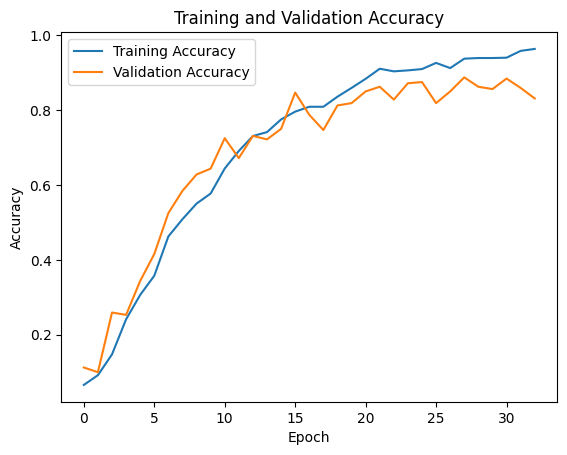

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

# Tracer la précision d'entraînement et de validation pour le modèle
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

---



---

**Performance du modèle avec VGG16 :**

>Précision d'entraînement : 96.76%, légèrement inférieure au modèle CNN personnalisé, mais plus stable.

>Précision de validation : 88.75%, nettement supérieure à celle du modèle personnalisé, ce qui indique une meilleure généralisation.

>Perte de validation : Diminue régulièrement, montrant une convergence stable.


---

---
# Conclusions

> Le CNN personnalisé est limité dans sa capacité à généraliser sur les données de validation et de test. Il peut convenir pour des tâches plus simples ou des datasets plus grands.

> VGG16 avec fine-tuning est plus efficace pour ce problème, car il exploite des caractéristiques générales pré-apprises d'ImageNet, adaptées aux images de voitures.